## DS5559 - Project
## Notebook 12 - Sentiment Analysis
### Novel: *Great Expectation* by Charles Dickens
#### Name: Mengyao Zhang (mz6jv), Runhao Zhao (rz6dg)

# Synopsis

Applying Syuzhet methods to *Great Expectation* by Charles Dickens using NRC, Bing, Syuzhet.

# Configuration

In [1]:
# Developed in other notebook
lex_db = 'lexicons.db'

# Developed in previous notebooks
text_db = 'project.db'
OHCO = ['book_num','chap_num', 'para_num', 'sent_num', 'token_num']
BOOKS = OHCO[:1] 
CHAPS = OHCO[:2]
PARAS = OHCO[:3]
SENTS = OHCO[:4]

novel_1 = '28' # book_number for "Great Expectation"
 

# emo = 'bing_sentiment'
emo = 'syu_sentiment'

# For KDE
kde_kernel = 'gaussian'
# kde_bandwidth = 100
kde_samples = 1000

# Libraries

In [2]:
import pandas as pd
import numpy as np
import scipy as sp
import sys
import scipy.fftpack as fftpack
from sklearn.neighbors import KernelDensity as KDE
from sklearn.preprocessing import scale

import sqlite3

import matplotlib.pyplot as plt
import seaborn as sns
from IPython.core.display import display, HTML

# Pragmas

In [3]:
%matplotlib inline
sns.set()
plt.style.use('fivethirtyeight')

# Process

## Get Lexicons

In [4]:
with sqlite3.connect(lex_db) as db:
    combo = pd.read_sql('SELECT * FROM combo', db, index_col='term_str')

In [5]:
combo.head()

,nrc_anger,nrc_anticipation,nrc_disgust,nrc_fear,nrc_joy,nrc_negative,nrc_positive,nrc_sadness,nrc_surprise,nrc_trust,bing_negative,bing_positive,bing_sentiment,syu_sentiment,gi_sentiment
term_str,,,,,,,,,,,,,,,
abandon,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,NaN,NaN,NaN,-0.75,-1.0
abandoned,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,NaN,NaN,NaN,-0.50,NaN
abandoner,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.25,NaN
abandonment,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,-0.25,-1.0
abandons,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.00,NaN


### Get lexicon columns

In [6]:
# emo_cols = [col for col in combo.columns if 'nrc_' in col]
emo_cols = combo.columns

In [7]:
emo_cols

Index(['nrc_anger', 'nrc_anticipation', 'nrc_disgust', 'nrc_fear', 'nrc_joy',
       'nrc_negative', 'nrc_positive', 'nrc_sadness', 'nrc_surprise',
       'nrc_trust', 'bing_negative', 'bing_positive', 'bing_sentiment',
       'syu_sentiment', 'gi_sentiment'],
      dtype='object')

## Analyze Pride and Prejudice 

## Get Text

In [8]:
with sqlite3.connect(text_db) as db:
    tokens = pd.read_sql("SELECT * FROM token WHERE book_num = {} AND punc = 0".format(novel_1), db, index_col=OHCO)
    vocab = pd.read_sql("SELECT * FROM vocab", db, index_col='term_id')

### Merge sentiment lexicon with vocab

In [9]:
tokens = tokens.join(combo, on='term_str', how='left')

In [10]:
tokens

pos    token_str  punc  num  \
book_num chap_num para_num sent_num token_num                                 
28       0        0        0        0            NN  ClassicBook     0    0   
                                    1            CD           28     0    1   
         1        0        0        0            NN      Chapter     0    0   
                                    1           PRP            I     0    0   
                  1        0        0          PRP$           My     0    0   
                                    1            NN       father     0    0   
                                    2           VBD            s     0    0   
                                    3            NN       family     0    0   
                                    4            NN         name     0    0   
                                    5           VBG        being     0    0   
                                    6           NNP       Pirrip     0    0   
                                    8            CC          and     0    0   
                                    9          PRP$           my     0    0   
                                    10           JJ    Christian     0    0   
                                    11           NN         name     0    0   
                                    12          NNP       Philip     0    0   
                                    14         PRP$           my     0    0   
                                    15           JJ       infant     0    0   
                                    16           NN       tongue     0    0   
                                    17           MD        could     0    0   
                                    18           VB         make     0    0   
                                    19           IN           of     0    0   
                                    20           DT         both     0    0   
                                    21          NNS        names     0    0   
                                    22           NN      nothing     0    0   
                                    23           RB       longer     0    0   
                                    24           CC           or     0    0   
                                    25          JJR         more     0    0   
                                    26          NNS     explicit     0    0   
                                    27           IN         than     0    0   
...                                             ...          ...   ...  ...   
         59       46       0        31           NN        forge     0    0   
                                    33           IN           so     0    0   
                                    34           DT          the     0    0   
                                    35           NN      evening     0    0   
                                    36          NNS        mists     0    0   
                                    37          VBD         were     0    0   
                                    38          VBG       rising     0    0   
                                    39           RB          now     0    0   
                                    41           CC          and     0    0   
                                    42           IN           in     0    0   
                                    43          PDT          all     0    0   
                                    44           DT          the     0    0   
                                    45           JJ        broad     0    0   
                                    46           NN      expanse     0    0   
                                    47           IN           of     0    0   
                                    48           NN     tranquil     0    0   
                                    49           NN        light     0    0   
                                    50          PRP         they     0    0   
                   

In [11]:
tokens[emo].sample(10)

book_num  chap_num  para_num  sent_num  token_num
28        42        11        2         13          -0.75
          25        53        3         46            NaN
          39        4         1         28            NaN
          35        53        0         13            NaN
          7         36        0         7             NaN
          53        64        0         1             NaN
          4         43        1         21            NaN
          51        1         0         12            NaN
          48        57        5         2            0.25
          29        55        1         6             NaN
Name: syu_sentiment, dtype: float64

In [12]:
tokens[emo_cols] = tokens[emo_cols].fillna(0)

In [13]:
tokens.head(10)

pos    token_str  punc  num  \
book_num chap_num para_num sent_num token_num                                 
28       0        0        0        0            NN  ClassicBook     0    0   
                                    1            CD           28     0    1   
         1        0        0        0            NN      Chapter     0    0   
                                    1           PRP            I     0    0   
                  1        0        0          PRP$           My     0    0   
                                    1            NN       father     0    0   
                                    2           VBD            s     0    0   
                                    3            NN       family     0    0   
                                    4            NN         name     0    0   
                                    5           VBG        being     0    0   

                                                  term_str  term_id  \
book_num chap_num para_num sent_num token_num                         
28       0        0        0        0          classicbook     6874   
                                    1                 None       -1   
         1        0        0        0              chapter     6192   
                                    1                    i    19667   
                  1        0        0                   my    25994   
                                    1               father    14694   
                                    2                    s    33971   
                                    3               family    14562   
                                    4                 name    26078   
                                    5                being     3406   

                                               nrc_anger  nrc_anticipation  \
book_num chap_num para_num sent_num token_num                                
28       0        0        0        0                0.0               0.0   
                                    1                0.0               0.0   
         1        0        0        0                0.0               0.0   
                                    1                0.0               0.0   
                  1        0        0                0.0               0.0   
                                    1                0.0               0.0   
                                    2                0.0               0.0   
                                    3                0.0               0.0   
                                    4                0.0               0.0   
                                    5                0.0               0.0   

                                               nrc_disgust  nrc_fear  \
book_num chap_num para_num sent_num token_num                          
28       0        0        0        0                  0.0       0.0   
                                    1                  0.0       0.0   
         1        0        0        0                  0.0       0.0   
                                    1                  0.0       0.0   
                  1        0        0                  0.0       0.0   
                                    1                  0.0       0.0   
                                    2                  0.0       0.0   
                                    3                  0.0       0.0   
                                    4                  0.0       0.0   
                                    5                  0.0       0.0   

                                                   ...       nrc_negative  \
book_num chap_num para_num sent_num token_num      ...                      
28       0        0        0        0              ...                0.0   
                                    1              ...                0.0   
         1        0        0        0              ...                0.0   
                                    1              ...     

## Sentiment by OHCO

In [14]:
FIG = dict(figsize=(25, 5), legend=True, fontsize=14, rot=45)

### By Chapter

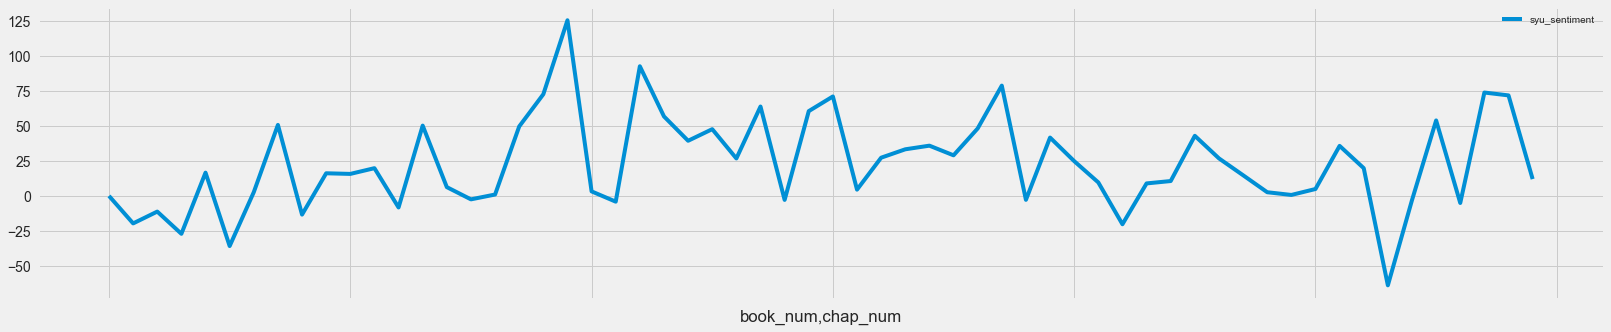

In [15]:
tokens.groupby(CHAPS)[emo].sum().plot(**FIG)

### By Paragraph

In [16]:
by_para = tokens.groupby(PARAS)[emo_cols].sum()

In [17]:
max_x = by_para.shape[0]
xticks = list(range(0, max_x, 100))
xticks.append(max_x - 1)

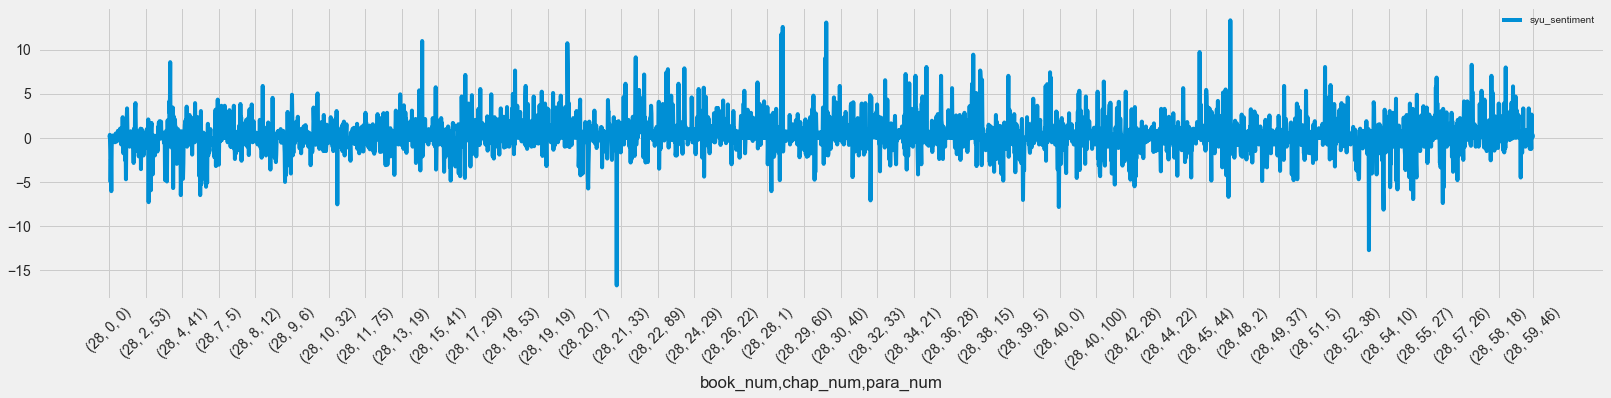

In [18]:
by_para[emo].plot(**FIG, xticks=xticks)

### By Sentence

In [19]:
by_sent = tokens.groupby(SENTS)[emo_cols].sum()

In [20]:
max_x = by_sent.shape[0]
xticks = list(range(0, max_x, 250))
xticks.append(max_x - 1)

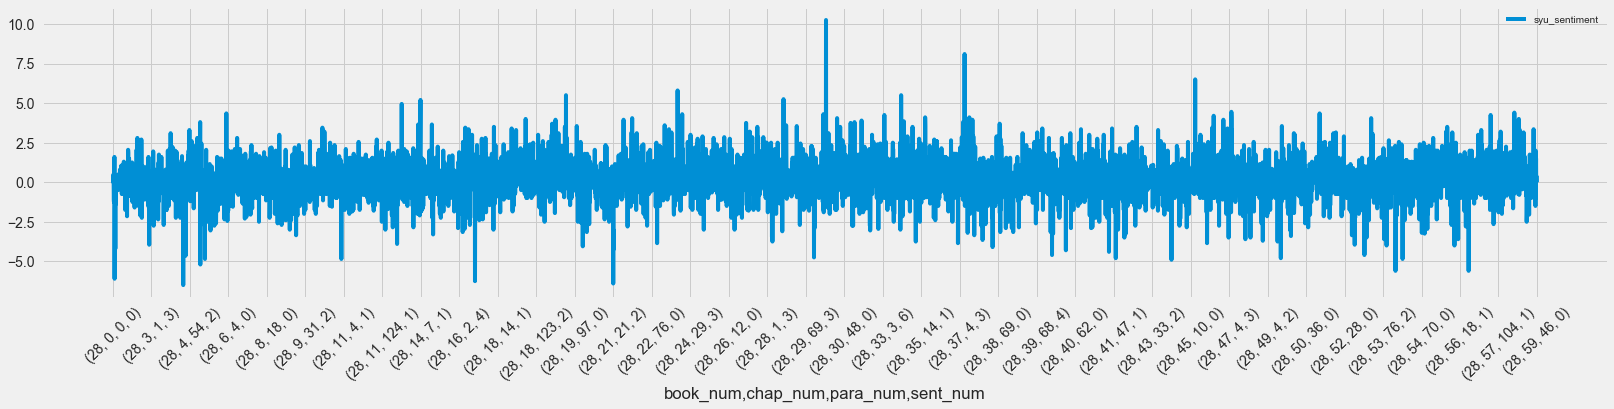

In [21]:
by_sent[emo].plot(**FIG, xticks=xticks)

### Add text to do spot checks

In [22]:
tokens['html'] =  tokens.apply(lambda x: 
                               "<span class='sent{}'>{}</span>".format(int(np.sign(x[emo])), x.token_str), 1)

In [23]:
tokens['html'].head()

book_num  chap_num  para_num  sent_num  token_num
28        0         0         0         0            <span class='sent0'>ClassicBook</span>
                                        1                     <span class='sent0'>28</span>
          1         0         0         0                <span class='sent0'>Chapter</span>
                                        1                      <span class='sent0'>I</span>
                    1         0         0                     <span class='sent0'>My</span>
Name: html, dtype: object

In [24]:
by_sent['sent_str'] = tokens.groupby(SENTS).term_str.apply(lambda x: x.str.cat(sep=' '))
by_sent['html_str'] = tokens.groupby(SENTS).html.apply(lambda x: x.str.cat(sep=' '))

In [25]:
by_sent[['sent_str', 'html_str']].head()

sent_str  \
book_num chap_num para_num sent_num                                                      
28       0        0        0                                               classicbook   
         1        0        0                                                 chapter i   
                  1        0         my father s family name being pirrip and my ch...   
                           1          so i called myself pip and came to be called pip   
                  2        0         i give pirrip as my father s family name on th...   

                                                                              html_str  
book_num chap_num para_num sent_num                                                     
28       0        0        0         <span class='sent0'>ClassicBook</span> <span c...  
         1        0        0         <span class='sent0'>Chapter</span> <span class...  
                  1        0         <span class='sent0'>My</span> <span class='sen...  
                           1         <span class='sent0'>So</span> <span class='sen...  
                  2        0         <span class='sent0'>I</span> <span class='sent...

### Histogram

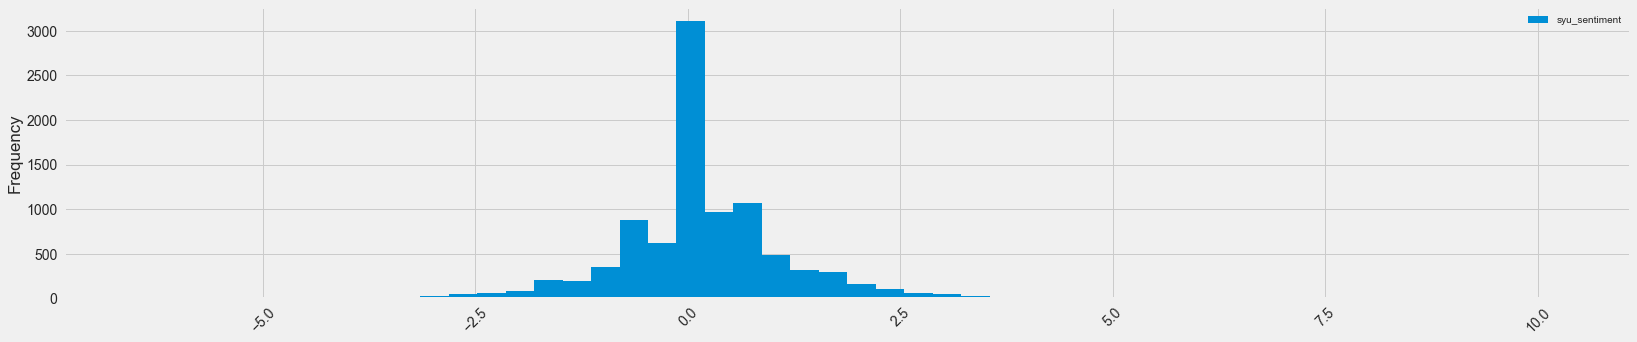

In [26]:
by_sent[emo].plot.hist(**FIG, bins=50)

### Look at a sample of sentences

In [27]:
rows = []
for idx in by_sent.sample(10).index:
    
    valence = round(by_sent.loc[idx, emo], 4)     
    t = 0
    if valence > t: color = '#ccffcc'
    elif valence < t: color = '#ffcccc'
    else: color = '#f2f2f2'
    z=0
    rows.append("""<tr style="background-color:{0};padding:.5rem 1rem;font-size:110%;">
    <td>{1}</td><td>{3}</td><td width="400" style="text-align:left;">{2}</td>
    </tr>""".format(color, valence, by_sent.loc[idx, 'html_str'], idx))
    
display(HTML('<style>#sample1 td{font-size:120%;vertical-align:top;} .sent-1{color:red;font-weight:bold;} .sent1{color:green;font-weight:bold;}</style>'))
display(HTML('<table id="sample1"><tr><th>Sentiment</th><th>ID</th><th width="600">Sentence</th></tr>'+''.join(rows)+'</table>'))

Sentiment,ID,Sentence
-0.75,"(28, 7, 77, 2)",And I doubt if even you ll go so far as that
-3.0,"(28, 21, 21, 3)",A frowzy mourning of soot and smoke attired this forlorn creation of Barnard and it had strewn ashes on its head and was undergoing penance and humiliation as a mere dust hole
0.0,"(28, 14, 0, 0)",Chapter XIV
-0.35,"(28, 31, 3, 1)",Whenever that undecided Prince had to ask a question or state a doubt the public helped him out with it
0.0,"(28, 7, 31, 0)",I didn t see but I didn t say so
0.05,"(28, 2, 7, 0)",Yes Pip said Joe and what s worse she s got Tickler with her
0.75,"(28, 57, 31, 3)",At my own writing table pushed into a corner and cumbered with little bottles Joe now sat down to his great work first choosing a pen from the pen tray as if it were a chest of large tools and tucking up his sleeves as if he were going to wield a crow bar or sledgehammer
0.0,"(28, 11, 33, 0)",No said I that s not it
-0.5,"(28, 36, 71, 3)",They must not be confounded together
0.0,"(28, 34, 14, 0)",Then Herbert I would respond let us look into our affairs


### Plot with Xticks

In [28]:
xticks = [0]
xticks += by_sent[emo].reset_index().sort_values(emo).head(7).index.values.tolist()
xticks += by_sent[emo].reset_index().sort_values(emo).tail(7).index.values.tolist()
xticks += [by_sent.shape[0] - 1]

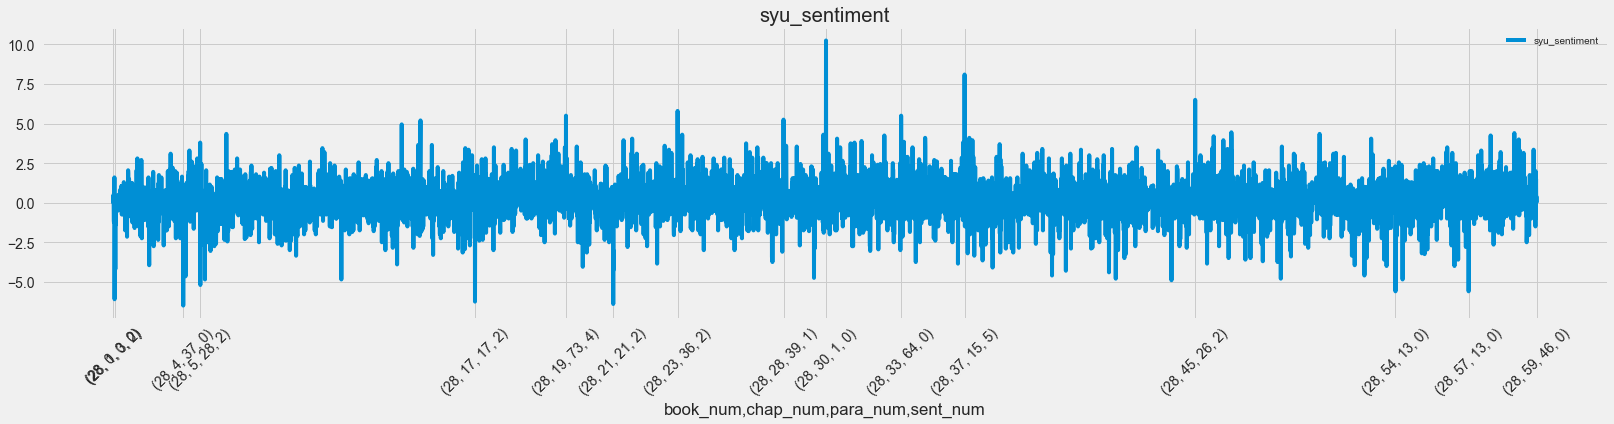

In [29]:
by_sent[emo].plot(**FIG, xticks=xticks, title=emo)

In [30]:
by_sent.iloc[xticks][emo].sort_index().to_frame()

syu_sentiment
book_num chap_num para_num sent_num               
28       0        0        0                  0.00
         1        3        2                 -6.10
         4        37       0                 -6.50
         5        28       2                 -5.20
         17       17       2                 -6.25
         19       73       4                  5.50
         21       21       2                 -6.40
         23       36       2                  5.80
         28       39       1                  5.25
         30       1        0                 10.25
         33       64       0                  5.50
         37       15       5                  8.10
         45       26       2                  6.50
         54       13       0                 -5.60
         57       13       0                 -5.60
         59       46       0                  0.00

### Inspect Positives

In [31]:
by_sent.sort_values(emo, ascending=False)[[emo,'sent_str']].head(20)

syu_sentiment  \
book_num chap_num para_num sent_num                  
28       30       1        0                 10.25   
         37       15       5                  8.10   
         45       26       2                  6.50   
         23       36       2                  5.80   
         33       64       0                  5.50   
         19       73       4                  5.50   
         28       39       1                  5.25   
         14       6        2                  5.20   
         13       15       0                  4.95   
         47       9        0                  4.45   
         58       37       2                  4.40   
         6        2        1                  4.35   
         51       30       6                  4.35   
         24       2        2                  4.30   
         29       115      2                  4.30   
         57       79       0                  4.25   
         33       8        0                  4.25   
         46       20       0                  4.20   
         35       25       3                  4.10   
         37       29       0                  4.10   

                                                                              sent_str  
book_num chap_num para_num sent_num                                                     
28       30       1        0         after well considering the matter while i was ...  
         37       15       5         for all these reasons i told wemmick and becau...  
         45       26       2         then he placed his breakfast before him with g...  
         23       36       2         i was pretty good at most exercises in which c...  
         33       64       0         mr. pocket being justly celebrated for giving ...  
         19       73       4         now it appeared to him pumblechook that if tha...  
         28       39       1         that the youth s earliest patron companion and...  
         14       6        2         it is not possible to know how far the influen...  
         13       15       0         which it is well beknown to yourself pip retur...  
         47       9        0         there i found a virtuous boatswain in his maje...  
         58       37       2         many pleasant pictures of the life that i woul...  
         6        2        1         but i loved joe perhaps for no better reason i...  
         51       30       6         i have seen your pleasant home and your old fa...  
         24       2        2         through his way of saying this and much more t...  
         29       115      2         in the interval miss havisham in a fantastic w...  
         57       79       0         the delicacy with which joe dismissed this the...  
         33       8        0         i was and i am sensible that the air of this c...  
         46       20       0         there was something so natural and winning in ...  
         35       25       3         i can be well recommended by all the neighbors...  
         37       29       0         all right john all right returned the cheerful...

### Inspect Negatives

In [32]:
by_sent.sort_values(emo, ascending=True)[[emo,'sent_str']].head(20)

syu_sentiment  \
book_num chap_num para_num sent_num                  
28       4        37       0                 -6.50   
         21       21       2                 -6.40   
         17       17       2                 -6.25   
         1        3        2                 -6.10   
         54       13       0                 -5.60   
         57       13       0                 -5.60   
         5        28       2                 -5.20   
         44       43       0                 -4.90   
         54       30       3                 -4.85   
         5        34       4                 -4.85   
         10       56       0                 -4.85   
         49       47       3                 -4.80   
         42       1        3                 -4.80   
         29       89       0                 -4.75   
         4        43       2                 -4.65   
         39       102      0                 -4.60   
         53       40       1                 -4.60   
                           2                 -4.50   
         41       32       2                 -4.40   
         40       46       0                 -4.30   

                                                                              sent_str  
book_num chap_num para_num sent_num                                                     
28       4        37       0         trouble echoed my sister trouble and then ente...  
         21       21       2         i thought the windows of the sets of chambers ...  
         17       17       2         i recalled the hopeless circumstances by which...  
         1        3        2         at such a time i found out for certain that th...  
         54       13       0         again among the tiers of shipping in and out a...  
         57       13       0         that i had a fever and was avoided that i suff...  
         5        28       2         and now when they were all in lively anticipat...  
         44       43       0         it would have been cruel in miss havisham horr...  
         54       30       3         for now the last of the fleet of ships was rou...  
         5        34       4         the sheep stopped in their eating and looked t...  
         10       56       0         i had sadly broken sleep when i got to bed thr...  
         49       47       3         and could i look upon her without compassion s...  
         42       1        3         in jail and out of jail in jail and out of jai...  
         29       89       0         she said the word often enough and there could...  
         4        43       2         instantly afterwards the company were seized w...  
         39       102      0         crowding up with these reflections came the re...  
         53       40       1         estella s father would believe i had deserted ...  
                           2         the death close before me was terrible but far...  
         41       32       2         it has almost made me mad to sit here of a nig...  
         40       46       0         he ate in a ravenous way that was very disagre...

## Apply Transforms

### Adapt Jockers' revised DCT function

Discrete Cosine Transform. A DCT is a Fourier-related transform similar to the discrete Fourier transform (DFT), but using only real numbers. 

In [33]:
def get_dct_transform(raw_values, low_pass_size = 5, x_reverse_len = 100):
    if low_pass_size > len(raw_values):
        raise ValueError("low_pass_size must be less than or equal to the length of raw_values input vector")
    values_dct = fftpack.dct(raw_values, type = 2)
    keepers = values_dct[:low_pass_size]
    padded_keepers = list(keepers) + list(np.zeros(x_reverse_len - low_pass_size))
    dct_out = fftpack.idct(padded_keepers)
    return(dct_out)

In [34]:
FFTCFG1 = dict(
    low_pass_size = 5,
    x_reverse_len = 100
)
X1 = get_dct_transform(by_sent[emo].values, **FFTCFG1)

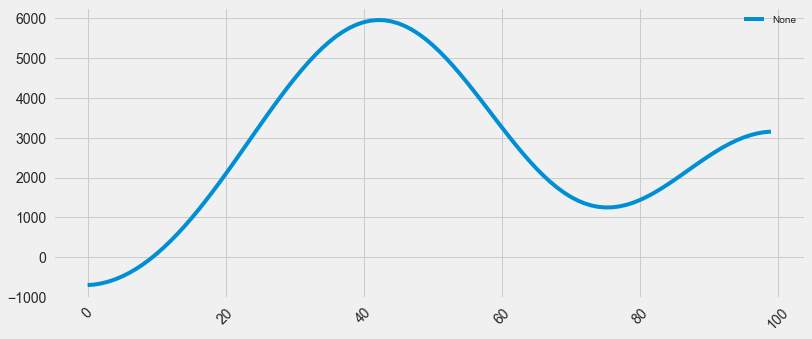

In [35]:
FIG['figsize'] = (12,5)
pd.Series(X1).plot(**FIG)

### Using Rolling
**Window types**: 
boxcar
triang
blackman
hamming
bartlett
parzen
bohman
blackmanharris
nuttall
barthann
kaiser (needs beta)
gaussian (needs std)
general_gaussian (needs power, width)
slepian (needs width).

In [36]:
by_sent.shape

(9248, 17)

In [37]:
# Config for sentences, change window size to 1000
CFG1 = dict(
    win_type='blackman',
    window=1000,
    center=True
)

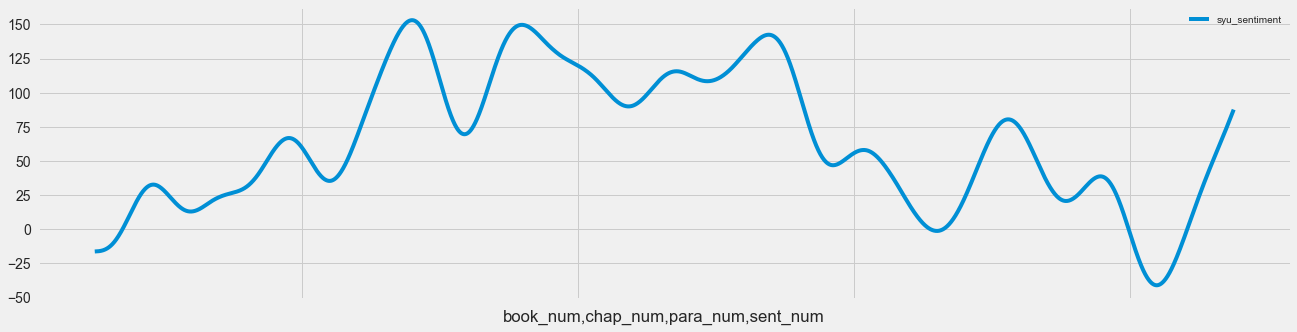

In [38]:
FIG['figsize'] = (20,5)
by_sent[emo].fillna(0).rolling(**CFG1).sum().plot(**FIG)

In [39]:
# Config for tokens
CFG2 = dict(
    win_type='blackman',
    window= int(tokens.shape[0]/ 10),
    center=True
)
CFG2['window']

18894

In [40]:
tokens.shape

(188943, 22)

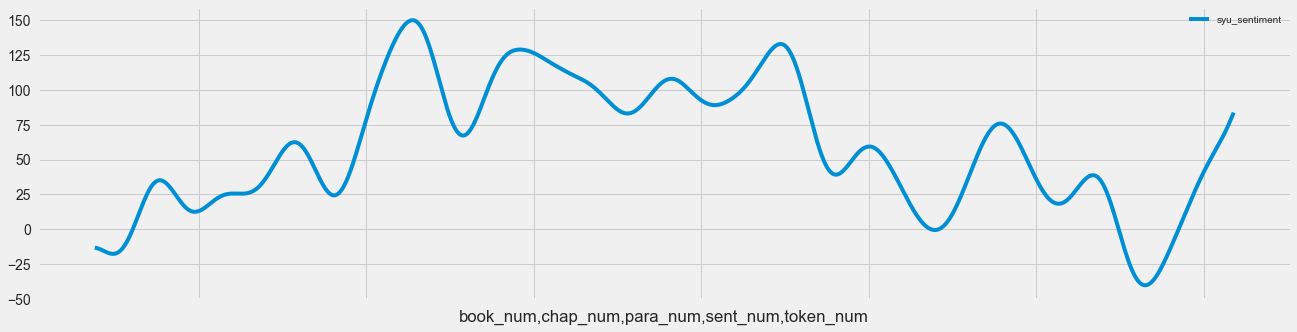

In [41]:
tokens[emo].fillna(0).rolling(**CFG2).sum().plot(**FIG)

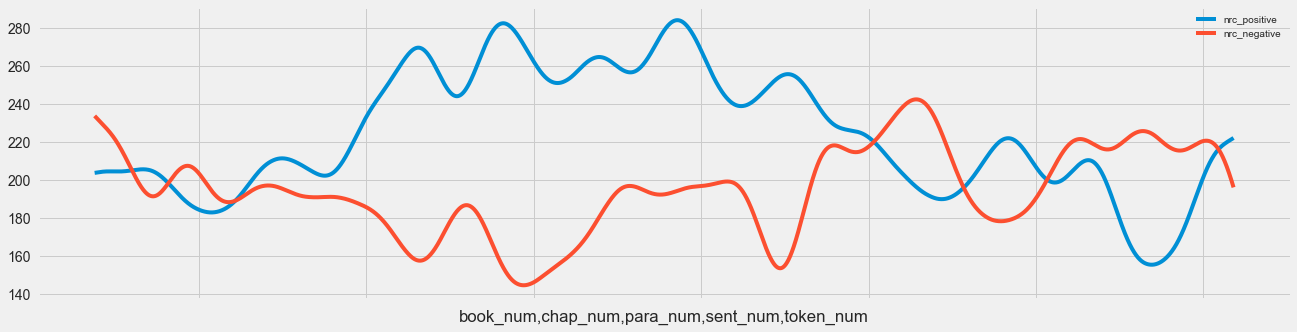

In [42]:
tokens[['nrc_positive','nrc_negative']].rolling(**CFG2).sum().plot(**FIG) 
plt.legend()
# positive is generally higher than negative

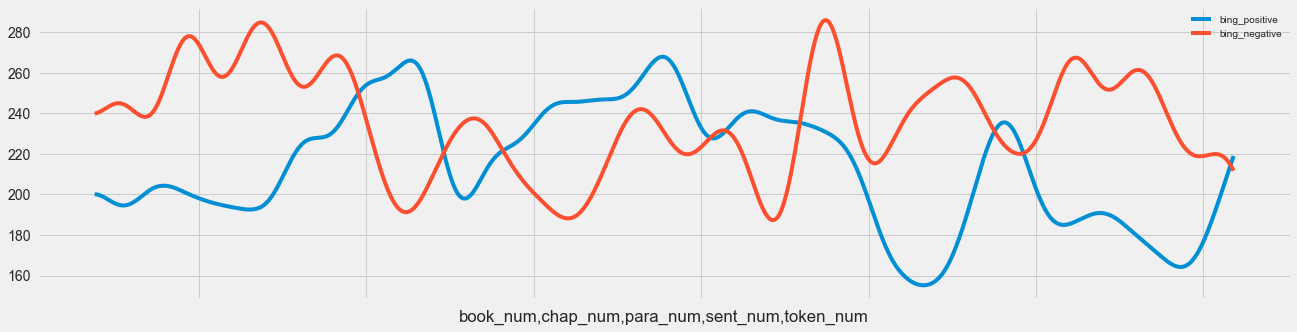

In [43]:
tokens[['bing_positive','bing_negative']].fillna(0).rolling(**CFG2).sum().plot(**FIG)
plt.legend()
# using bing lexicon 

## Multinomial Emotions

In [44]:
EOM = tokens[emo_cols].reset_index(drop=True)

In [45]:
EOM.head()

,nrc_anger,nrc_anticipation,nrc_disgust,nrc_fear,nrc_joy,nrc_negative,nrc_positive,nrc_sadness,nrc_surprise,nrc_trust,bing_negative,bing_positive,bing_sentiment,syu_sentiment,gi_sentiment
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


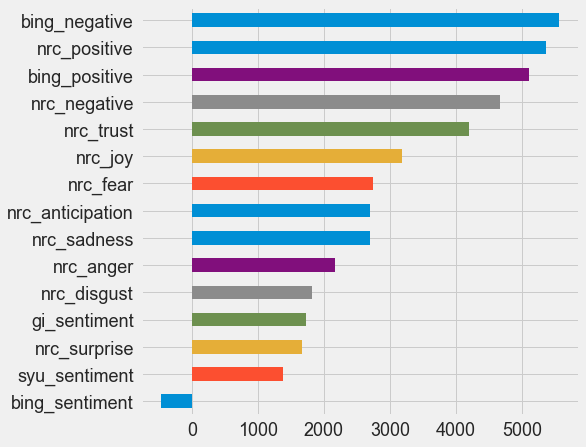

In [46]:
EOM.sum().sort_values().plot.barh(figsize=(7,7), fontsize=18)
# negative - high

### Shape data for Sklearn's KDE function

In [47]:
emo_offsets = []
for col in emo_cols:
    x = EOM[EOM[col] > 0].index.tolist()
    y = [[i] for i in x]
    emo_offsets.append((col, y))
B = pd.DataFrame(emo_offsets, columns=['emo', 'x'])
B = B.set_index('emo')

In [48]:
B

,x
emo,
nrc_anger,"[[164], [180], [209], [259], [386], [420], [44..."
nrc_anticipation,"[[17], [75], [156], [337], [352], [436], [442]..."
nrc_disgust,"[[160], [420], [442], [455], [699], [708], [73..."
nrc_fear,"[[17], [183], [209], [259], [328], [337], [346..."
nrc_joy,"[[17], [75], [156], [218], [268], [286], [296]..."
nrc_negative,"[[75], [133], [156], [160], [164], [180], [183..."
nrc_positive,"[[17], [53], [75], [156], [218], [268], [286],..."
nrc_sadness,"[[75], [133], [156], [160], [183], [209], [259..."
nrc_surprise,"[[17], [286], [337], [542], [690], [754], [104..."


### Get KDE for each emotion

In [49]:
scale_max = EOM.shape[0]
kde_bandwidth = 2500
# kde_bandwidth = 250
x_axis = np.linspace(0, scale_max, kde_samples)[:, np.newaxis]
B['kde'] = B.apply(lambda row: KDE(kernel=kde_kernel, bandwidth=kde_bandwidth).fit(row.x), 1)
B['scores'] = B.apply(lambda row: row.kde.score_samples(x_axis), axis=1)

### Visualize KDE plots

In [50]:
PLOTS = B.apply(lambda row: pd.Series(np.exp(row.scores) * (scale_max / kde_samples)), axis=1).T

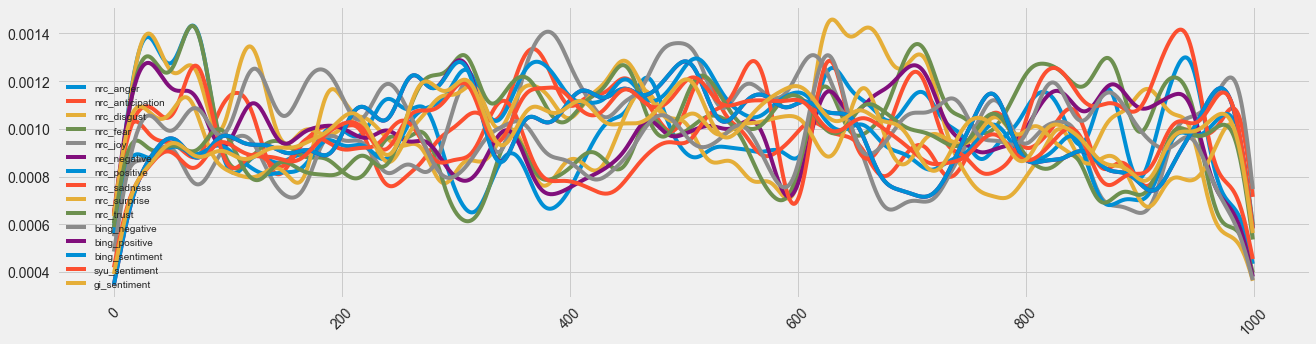

In [51]:
PLOTS.plot(**FIG)
plt.legend()

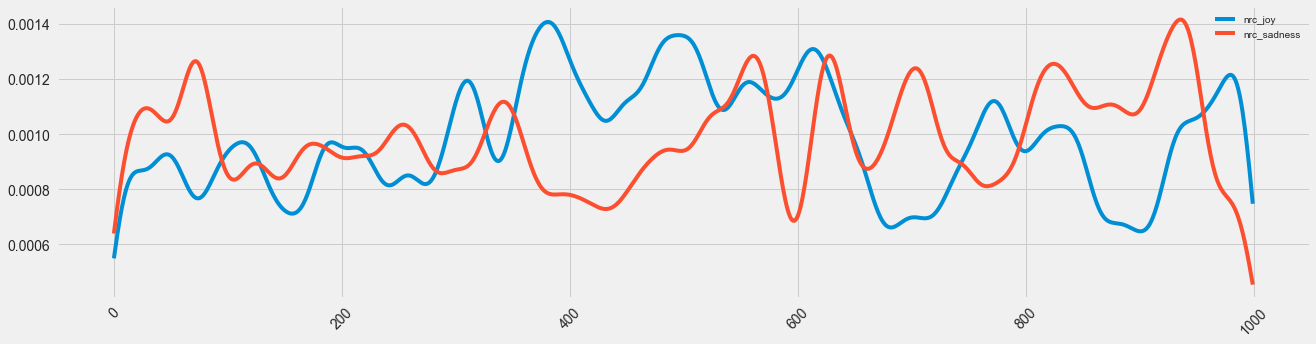

In [52]:
PLOTS[['nrc_joy','nrc_sadness']].plot(**FIG)
plt.legend()

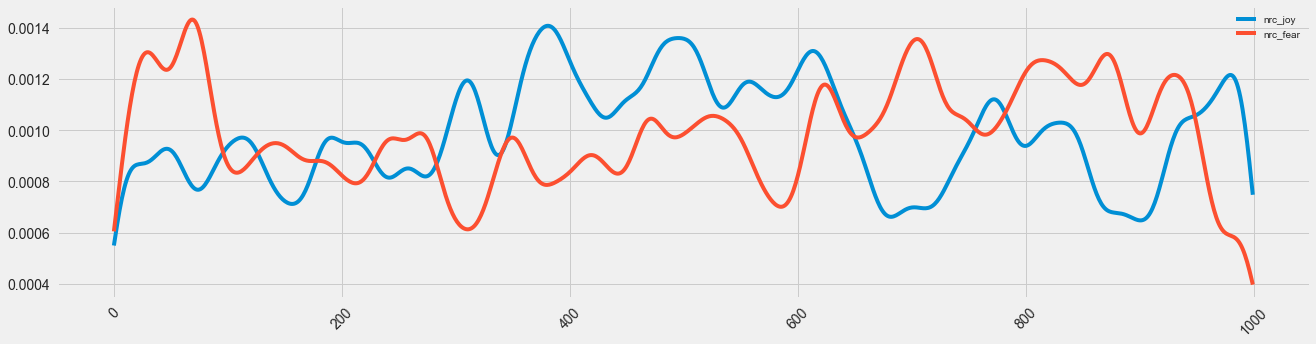

In [79]:
PLOTS[['nrc_joy','nrc_fear']].plot(**FIG)
plt.legend()

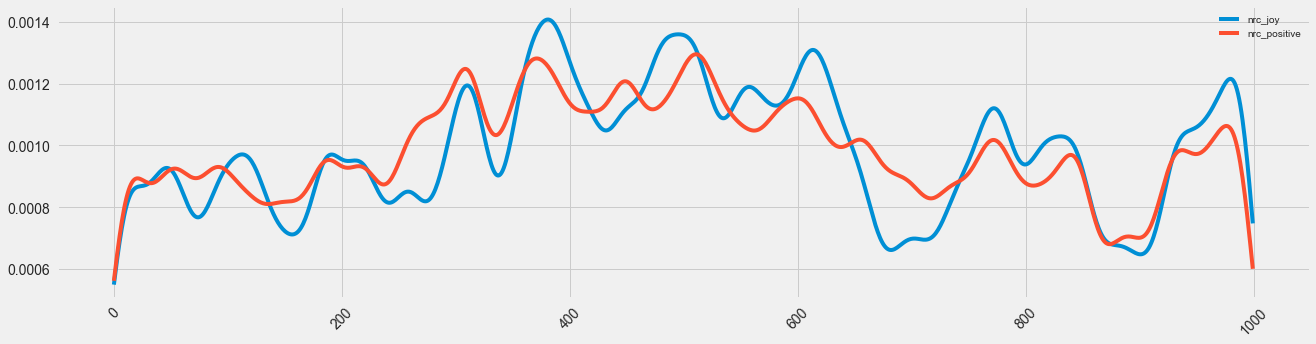

In [53]:
PLOTS[['nrc_joy','nrc_positive']].plot(**FIG)
plt.legend()

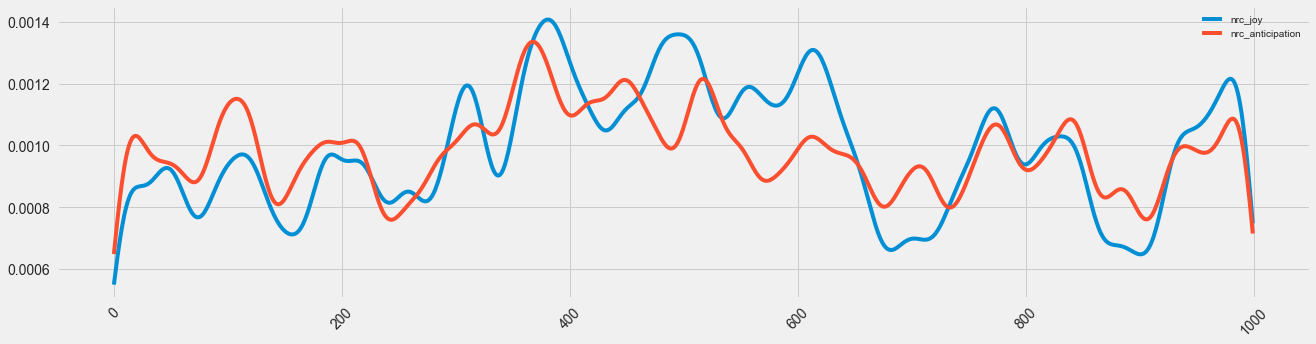

In [54]:
PLOTS[['nrc_joy','nrc_anticipation']].plot(**FIG)
plt.legend()

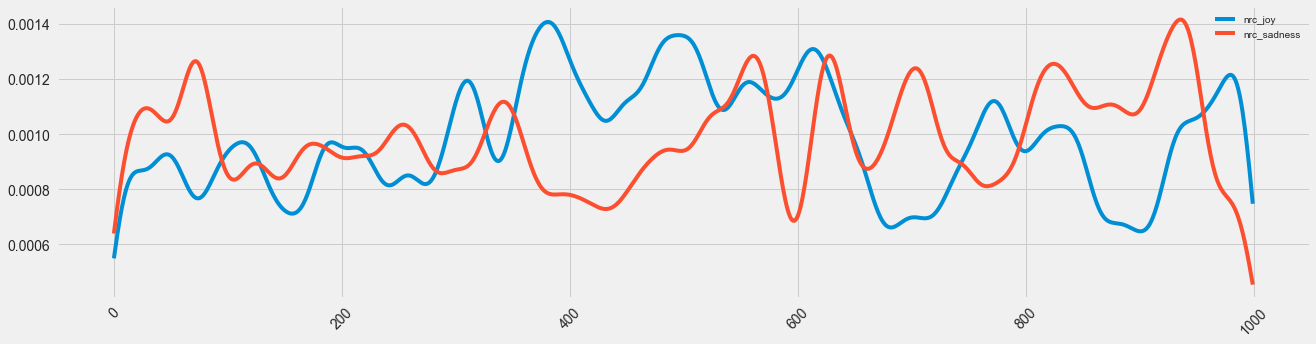

In [55]:
PLOTS[['nrc_joy','nrc_sadness']].plot(**FIG)
plt.legend()

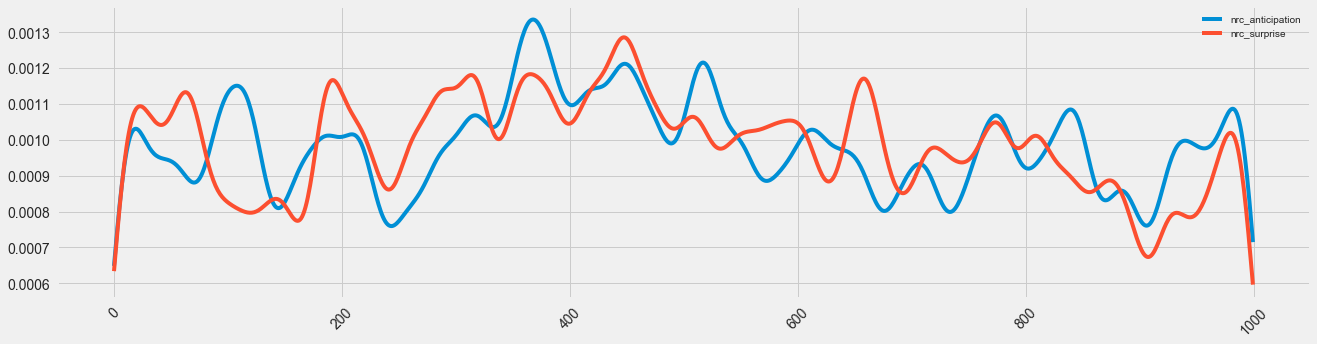

In [56]:
PLOTS[['nrc_anticipation','nrc_surprise']].plot(**FIG)
plt.legend()

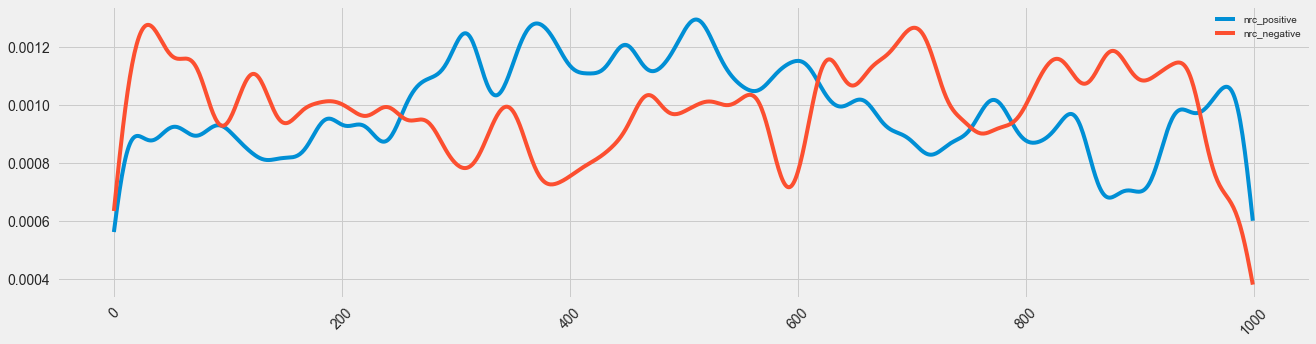

In [57]:
PLOTS[['nrc_positive','nrc_negative']].plot(**FIG)
plt.legend()

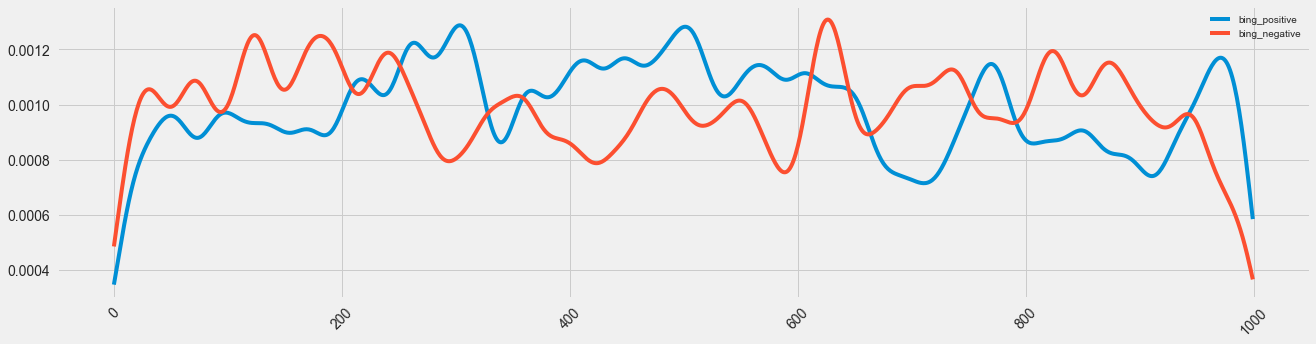

In [58]:
PLOTS[['bing_positive','bing_negative']].plot(**FIG)
plt.legend()

### Compare KDE to Rolling graphs of Sentiment

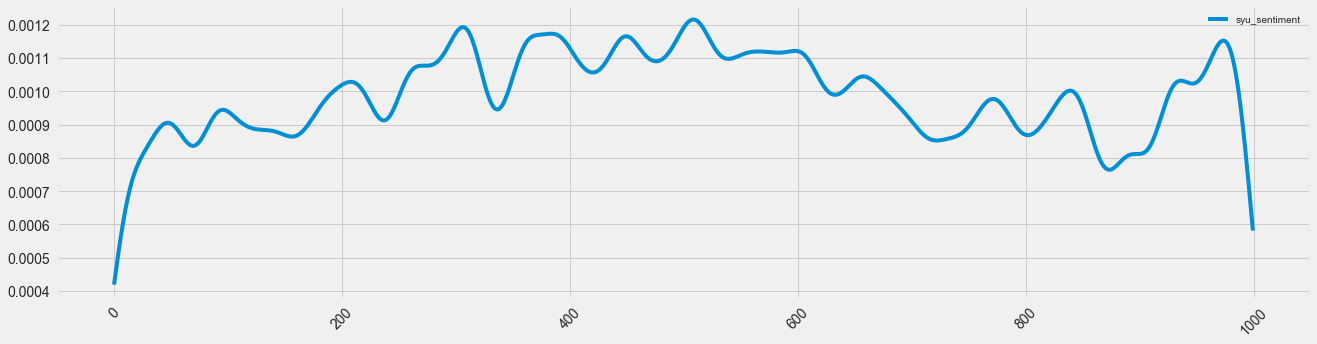

In [59]:
PLOTS[emo].plot(**FIG)

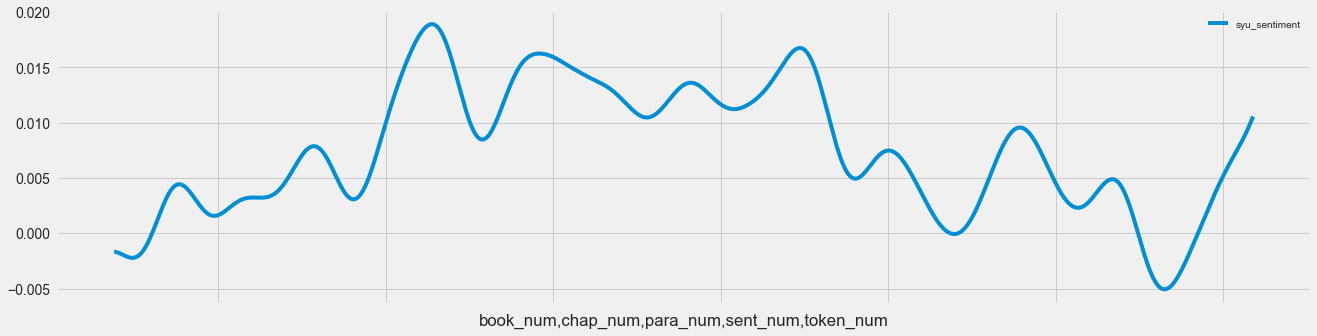

In [60]:
tokens[emo].fillna(0).rolling(**CFG2).mean().plot(**FIG)

## Peak Joy

### Find max joy from PLOTS

In [61]:
PLOTS.head()

emo,nrc_anger,nrc_anticipation,nrc_disgust,nrc_fear,nrc_joy,nrc_negative,nrc_positive,nrc_sadness,nrc_surprise,nrc_trust,bing_negative,bing_positive,bing_sentiment,syu_sentiment,gi_sentiment
0,0.000584,0.000648,0.000556,0.000605,0.000550,0.000634,0.000562,0.000640,0.000634,0.000588,0.000486,0.000347,0.000347,0.000419,0.000391
1,0.000624,0.000685,0.000595,0.000642,0.000579,0.000672,0.000593,0.000673,0.000672,0.000621,0.000516,0.000371,0.000371,0.000444,0.000417
2,0.000665,0.000721,0.000636,0.000680,0.000608,0.000710,0.000623,0.000705,0.000709,0.000653,0.000546,0.000396,0.000396,0.000469,0.000442
3,0.000705,0.000755,0.000677,0.000718,0.000636,0.000748,0.000652,0.000736,0.000745,0.000685,0.000576,0.000420,0.000420,0.000494,0.000467
4,0.000746,0.000789,0.000718,0.000755,0.000662,0.000785,0.000680,0.000767,0.000780,0.000715,0.000606,0.000445,0.000445,0.000518,0.000492


In [83]:
PEAK_JOY = int((PLOTS['nrc_joy'].idxmax() / 1000) * tokens.shape[0])

In [119]:
PEAK_JOY_CHAP_NUM = tokens.iloc[PEAK_JOY].name[1]

In [144]:
PEAK_JOY_CHAP_NUM  # the chapter where peak joy appeared

22

### Display Chapter

In [135]:
PEAK_JOY_CHAP = tokens.reset_index()[tokens.reset_index().chap_num==(PEAK_JOY_CHAP_NUM)].groupby(['para_num']).token_str.apply(lambda x: ' '.join(x)).tolist()

In [136]:
display(HTML('<br/><br/>'.join(PEAK_JOY_CHAP)))

## Peak Fear

### Find max fear from PLOTS

In [123]:
PEAK_FEAR = int((PLOTS['nrc_fear'].idxmax() / 1000) * tokens.shape[0])

In [124]:
PEAK_FEAR_CHAP_NUM = tokens.iloc[PEAK_FEAR].name[1]

In [137]:
PEAK_FEAR_CHAP_NUM  # the chapter where peak fear appeared

5

### Display Chapter

In [138]:
PEAK_FEAR_CHAP = tokens.reset_index()[tokens.reset_index().chap_num==PEAK_FEAR_CHAP_NUM].groupby(['para_num']).token_str.apply(lambda x: ' '.join(x)).tolist()

In [139]:
display(HTML('<br/><br/>'.join(PEAK_FEAR_CHAP)))

## Experimental Plotting Function

In [140]:
def  plot_sentiment(emo_col, type='sent'):
    if type == 'sent':
        by_sent[emo_col].fillna(0).rolling(**CFG1).mean().plot(**FIG)
    elif type == 'tokens':
        tokens[emo_col].fillna(0).rolling(**CFG2).mean().plot(**FIG)
    elif type == 'kde':
        PLOTS[emo_col].plot(**FIG)
    else:
        pass

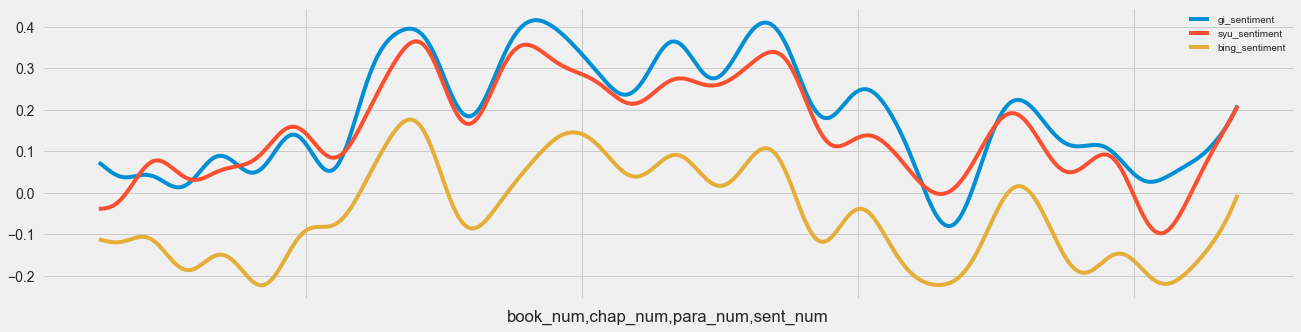

In [141]:
plot_sentiment('gi_sentiment')
plot_sentiment('syu_sentiment')
plot_sentiment('bing_sentiment')

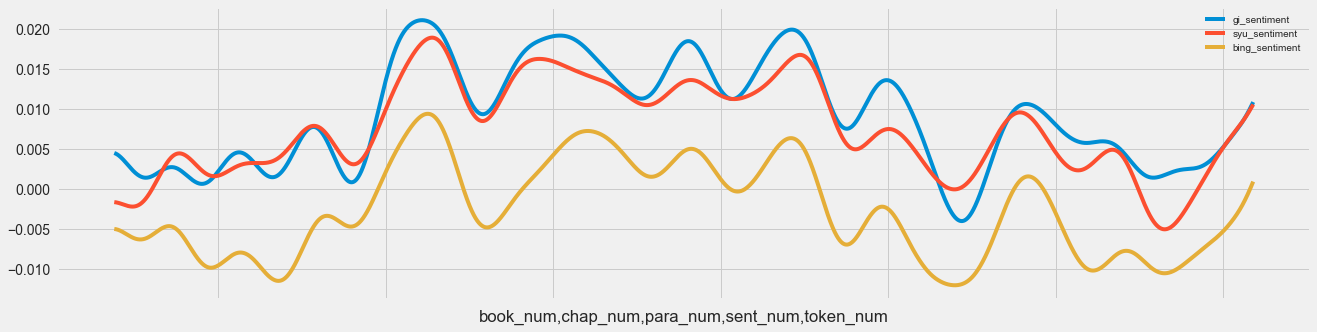

In [142]:
plot_sentiment('gi_sentiment', type='tokens')
plot_sentiment('syu_sentiment', type='tokens')
plot_sentiment('bing_sentiment', type='tokens')

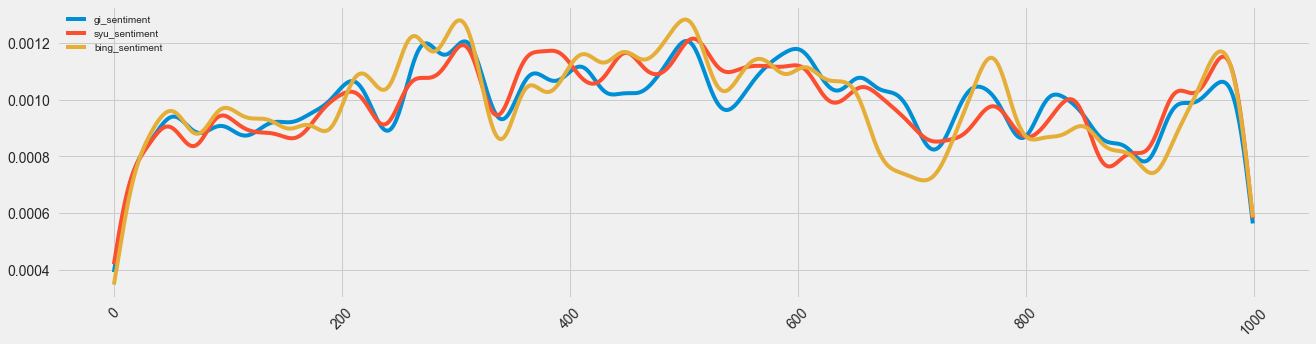

In [143]:
plot_sentiment('gi_sentiment', type='kde')
plot_sentiment('syu_sentiment', type='kde')
plot_sentiment('bing_sentiment', type='kde')

In [ ]:
# End